# 方策評価 ~ ベルマン方程式を解く~
## 1. 強化学習の流れとイメージ

目標 : 最適な方策$\pi$を求める.
* step1 : 適当に方策$\pi$を決める.
* step2 : その方策でゲームをやってみる.$V^{\pi}(s)$または$Q^{\pi}(s, a)$を求めることでフィードバックを得る. 
* step3 : 求まった$V^{\pi}(s)$または$Q^{\pi}(s, a)$から方策$\pi$を評価 & 改善する.
* step4 : step1に戻る. $\pi$が収束するまで繰り返す.

## 2. 状態価値関数 $V^{\pi}(s)$

### 2.1 状態価値関数の定義
方策 $\pi$ を1つ決めた時の状態 $s$ の価値を表す関数 $ V^{\pi}(s) : S \mapsto \mathbb{R} $ を定義する.
$$ \begin{eqnarray}
     V^{\pi} (s) &=& \mathbb{E}[ \sum_{n=t}^{\infty} \gamma^{n-t} r_n  ; s_t = s ] \\
     &=& \mathbb{E}[ r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \cdots  ; s_t = s ] \\
     &=& \mathbb{E}[r_t] + \gamma \mathbb{E}[ \sum_{n=t+1}^{\infty} \gamma^{n-(t+1)} r_n  ; s_t = s ] \ ( \text{期待値の線形性})
\end{eqnarray}$$

状態 $s$ の状態価値とは : 
<center> 状態 $s$ から, 方策$\pi$に従って行動した時, 将来得ることのできる収益の期待値(理論上の平均). </center>

### 2.2 状態価値関数のベルマン方程式

<img src="https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.amazonaws.com%2F0%2F233208%2F3be2fdc2-aa91-2af6-eb76-663f7f167188.jpeg?ixlib=rb-1.2.2&auto=compress%2Cformat&fit=max&s=92446f64725c6574d8101b6c52416907" width = "500" >

状態 $s_t$ から方策$\pi$に従って, 行動$a_t$が決まる. $s_t, a_t$ から遷移確率$P$に従って次の状態$s_{t+1}$が決まる.

期待値の定義通り, 全ての場合の確率と報酬の積を足し合わせることで, 以下の値を求める.
1. $\mathbb{E}[r_t]$ を求める. ( ただし,  $ s_t = s $ )
$$\mathbb{E}[r_t] = \sum_{a \in A} \pi(s, a) \sum_{s' \in S} P(s, a, s') r( s, a, s' ) $$

2. $\mathbb{E}[ \sum_{n=t+1}^{\infty} \gamma^{n-(t+1)} r_n  ; s_t = s ] $ を求める.  ( ただし,  $ s_t = s $ )
$$ \begin{eqnarray}
\mathbb{E}[ \sum_{n=t+1}^{\infty} \gamma^{n-(t+1)} r_n  ; s_t = s ] 
&=& \sum_{a \in A} \pi(s, a) \sum_{s' \in S} P(s, a, s') \mathbb{E}[ \sum_{n=t+1}^{\infty} \gamma^{n-(t+1)} r_n  ; s_{t+1} = s' ] \\
&=& \sum_{a \in A} \pi(s, a) \sum_{s' \in S} P(s, a, s') V^{\pi}(s')
\end{eqnarray} $$

よって以下の式が求まり, これをベルマン方程式と呼ぶ.
$$ V^{\pi} (s) = \sum_{a \in A} \pi(s, a) \sum_{s' \in S} P(s, a, s') ( r( s, a, s' ) + \gamma V^{\pi}(s')) $$

### 2.3 状態価値関数を求める. ( 遷移確率 $P$ は既知 )

求める方法 : 
* $V^{\pi}$に対応する再帰関数を作って近似的に求める.
* べルマン方程式を連立して, 連立1次方程式を厳密に解く.
* 反復法を用いて連立1次方程式を近似的に解く. 

理解を深めるために全部の方法で解いてみる.

題材は, さっきと同じ迷路ゲーム.

ちなみに, 迷路ゲームでは遷移確率$P$は考えなくて良いのでベルマン方程式が簡単に書けて, 
$$ V^{\pi} (s) = \sum_{a \in A} \pi(s, a) ( r( s, a, s' ) + \gamma V^{\pi}(s')) $$

In [44]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
# 1. 再帰関数を用いた実装
S = [i for i in range(9)]
A = ["up", "right", "down", "left"]

# 報酬関数
def reward(s, a, s_next):
    if s_next == 8:
        return 10.0
    # [変更!!] s5についたら罰報酬 -5.0
    if s_next == 5:
        return -5.0
    else:
        return 0.0


# 方策 pi を適当に決める.
pi_0 = np.array(
    [[0.0, 0.5, 0.5, 0.0],
     [0.0, 0.5, 0.0, 0.5],
        [0.0, 0.0, 0.5, 0.5],
        [1.0/3,  1.0/3, 1.0/3,  0.0],
        [0.0, 0.0, 0.5, 0.5],
        [1.0, 0.0, 0.0, 0.0],
        [1.0, 0.0, 0.0, 0.0],
        [0.5, 0.5, 0.0, 0.0]])

# 割引率
gamma = 0.95

# 行動番号を返す.


def action_idx(a):
    if a == "up":
        action = 0
    elif a == "right":
        action = 1
    elif a == "down":
        action = 2
    elif a == "left":
        action = 3
    return action

# 次の場所を返す.


def next_s(s, a):
    if a == "up":
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif a == "right":
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif a == "down":
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif a == "left":
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる
    return s_next

# 状態sで行動aを選択可能か(True / False)


def valid_action(s, a):
    if s == 0:
        return ((a == "right") or (a == "down"))
    elif s == 1:
        return (a == "right" or a == "left")
    elif s == 2:
        return (a == "left" or a == "down")
    elif s == 3:
        return (a != "left")
    elif s == 4:
        return (a == "left" or a == "down")
    elif s == 5:
        return (a == "up")
    elif s == 6:
        return (a == "up")
    elif s == 7:
        return (a == "up" or a == "right")
    elif s == 8:
        return False

def V_pi(s, depth, pi):
    # 再帰の深さを10でやめる. V^pi(s) = 0 とする.
    if s == 8 or depth == 10:
        return 0
    value = 0.0
    for a in A:
        if valid_action(s, a):
            action, s_next = action_idx(a), next_s(s, a)
            value += (pi[s, action] * ( reward(s, action, s_next) + gamma * V_pi(s_next, depth+1, pi)))
    return value

In [46]:
# 状態価値関数を計算
V_rec = []
for s_0 in S:
    V_rec.append(V_pi(s_0, 1, pi_0))
print(V_rec)

[-1.1414749661928529, -3.2728999638474634, -7.0378651094694344, 1.4367223394957174, 3.6898103683695753, -5.9282501244225383, 1.0351116230074278, 6.8363193337461396, 0]


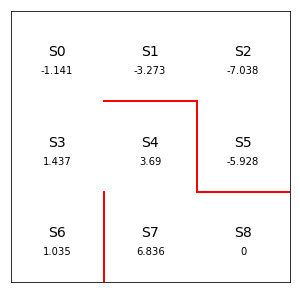

In [47]:
# 状態価値関数を図示.
def plot_V_pi(V_pi):
    # 初期位置での迷路の様子
    # 図を描く大きさと、図の変数名を宣言
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()

    # 赤い壁を描く
    plt.plot([1, 1], [0, 1], color='red', linewidth=2)
    plt.plot([1, 2], [2, 2], color='red', linewidth=2)
    plt.plot([2, 2], [2, 1], color='red', linewidth=2)
    plt.plot([2, 3], [1, 1], color='red', linewidth=2)

    # 状態を示す文字S0～S8を描く
    xy = []
    i = 0
    for y in [2.5, 1.5, 0.5]:
        for x in [0.5, 1.5, 2.5]:
            plt.text(x,y , "S"+str(i) , size=14, ha='center')
            plt.text(x, y-0.2, str(round(V_pi[i], 3)), ha='center')
            i += 1
        
    # 描画範囲の設定と目盛りを消す設定
    ax.set_xlim(0, 3)
    ax.set_ylim(0, 3)
    plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

plot_V_pi(V_rec)

In [48]:
# 連立方程式の表示
def simulataneous_equation_show(pi):
    for s in S:
        eq = "-V(S{0})".format(s)
        for a in A:
            if valid_action(s, a):
                action, s_next = action_idx(a), next_s(s, a)
                r = reward(s, action, s_next)
                if r != 0:
                    eq += " + {0} * {1} + {0} * {3} * V({2})".format(round(pi[s, action],2), r, "S"+str(s_next), gamma)
                else:
                    eq += " + {0} * {2} * V({1})".format(round(pi[s, action],2), "S"+str(s_next), gamma)
        print(eq + " = 0")
simulataneous_equation_show(pi_0)

-V(S0) + 0.5 * 0.95 * V(S1) + 0.5 * 0.95 * V(S3) = 0
-V(S1) + 0.5 * 0.95 * V(S2) + 0.5 * 0.95 * V(S0) = 0
-V(S2) + 0.5 * -5.0 + 0.5 * 0.95 * V(S5) + 0.5 * 0.95 * V(S1) = 0
-V(S3) + 0.33 * 0.95 * V(S0) + 0.33 * 0.95 * V(S4) + 0.33 * 0.95 * V(S6) = 0
-V(S4) + 0.5 * 0.95 * V(S7) + 0.5 * 0.95 * V(S3) = 0
-V(S5) + 1.0 * 0.95 * V(S2) = 0
-V(S6) + 1.0 * 0.95 * V(S3) = 0
-V(S7) + 0.5 * 0.95 * V(S4) + 0.5 * 10.0 + 0.5 * 0.95 * V(S8) = 0
-V(S8) = 0


In [49]:
# 連立1次方程式を直接法で解く.
def simulataneous_equation(pi):
    L = np.zeros((9, 9))
    b = np.zeros(9)
    for i, s in enumerate(S):
        L[i, s] = 1.0
        for a in A:
            if valid_action(s, a):
                action, s_next = action_idx(a), next_s(s, a)
                r = reward(s, action, s_next)
                if r != 0:
                    L[i, s_next] = - gamma * pi[s, action]
                    b[i] = pi[s, action] * r
                else:
                    L[i, s_next] = - gamma* pi[s, action]
    return np.linalg.inv(L) @ b

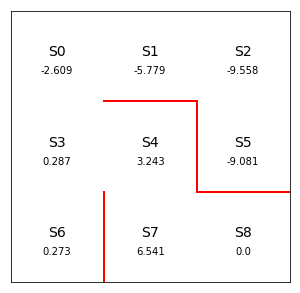

In [50]:
# 厳密解法. 
plot_V_pi(simulataneous_equation(pi_0))

#### 2.3.3 反復解法
一般的に連立一次方程式 $A \boldsymbol{x} = \boldsymbol{b}$ の解法には, 直接法と反復法がある. ( 数値計算の分野 ) <br>
参考 : [線形方程式の解法:反復法](http://nkl.cc.u-tokyo.ac.jp/13n/SolverIterative.pdf)

> 反復法とは, 適当な初期解 $\boldsymbol{x_0}$ から始めて繰り返し計算によって $\boldsymbol{x_1},\ \boldsymbol{x_2}, \dots $ と求めて, 真の解に収束させる解法

反復法の1つである<font color="red"> ヤコビ法 </font> を用いる方法がベルマン方程式を解く時には有名のよう(?).

一般に, 反復法を用いる時はちゃんと収束するのか条件を確かめる必要がある.

ヤコビ法が収束する十分条件

$$ \text{係数行列} A \text{が対角優位性をもつ} \underset{def}{\Leftrightarrow}  | a_{i,i} | > \sum_{ j = 1,\ j \neq i}^n | a_{i,j} | $$
をベルマン方程式は常に満たす. <br>
( 対角成分は1, 各行の非対角成分は確率 $\pi$ と割引率 $\gamma$ の積だから和は1より小さくなる. ) 

- - -

最初に適当に$V^{\pi}_{0}(s)$を初期化する.

$$ V^{\pi}_{k+1}(s) \leftarrow \sum_{a \in A} \pi(s, a) \sum_{s' \in S} P(s, a, s') ( r( s, a, s' ) + \gamma V^{\pi}_{k} (s')) $$

この更新式に従って, 更新を繰り返せば真の$V^{\pi}$に収束する.

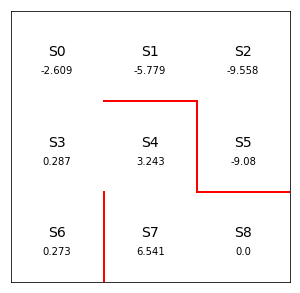

In [51]:
def iteration_solve(pi):
    V = np.random.rand(len(S))
    stop_epsilon = 10**-4
    while True:
        V_new = np.zeros_like(V)
        for s in S:
            for a in A:
                if valid_action(s, a):
                    action, s_next = action_idx(a), next_s(s, a)
                    V_new[s] += pi[s, action] * (reward(s, action, s_next) + gamma*V[s_next])
        if np.sum(np.abs(V_new - V)) < stop_epsilon:
            break
        else:
            V = V_new
    return V

plot_V_pi(iteration_solve(pi_0))